# Model Training & Evaluation

## Обучение CatBoost и LightGBM моделей

**Цель:** Предсказать вероятность заказа в августе 2024

**Подход:**
1. Train/validation split со стратификацией
2. CatBoost (основная модель)
3. LightGBM (для сравнения)
4. Ensemble (weighted average)
5. Feature importance анализ
6. Submission generation

**Метрики:** AUC-ROC, Precision, Recall, F1-score

## 1. Imports and Configuration

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve

import catboost
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded!")
print(f"CatBoost version: {catboost.__version__}")
print(f"LightGBM version: {lgb.__version__}")

Libraries loaded!
CatBoost version: 1.2.8
LightGBM version: 4.6.0


In [2]:
# Configuration
DATA_DIR = '../results'
MODELS_DIR = '../models'
SUBMISSION_DIR = '../results'

# Create directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(SUBMISSION_DIR, exist_ok=True)

# Random seed for reproducibility
RANDOM_STATE = 42

# Cross-validation settings
N_FOLDS = 5

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Random state: {RANDOM_STATE}")
print(f"CV folds: {N_FOLDS}")

Data directory: ../results
Models directory: ../models
Random state: 42
CV folds: 5


## 2. Load Features

In [3]:
# Load training and test features
print("Loading features...")

df_train = pd.read_parquet(os.path.join(DATA_DIR, 'features_train_v2.parquet'))
df_test = pd.read_parquet(os.path.join(DATA_DIR, 'features_test_v2.parquet'))

print(f"\nTrain shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")


# Display sample
print("\nTrain sample:")
print(df_train.head())

Loading features...

Train shape: (1835147, 337)
Test shape: (2068424, 337)

Train sample:
   user_id  target  num_products_click  num_unique_products_click  \
0       16       0                 1.0                        1.0   
1       34       0                -1.0                       -1.0   
2       36       1                 9.0                        9.0   
3       53       0                -1.0                       -1.0   
4       54       0                 1.0                        1.0   

   sum_discount_price_click  max_discount_price_click  days_since_last_click  \
0                     335.0                     335.0                  118.0   
1                      -1.0                      -1.0                   -1.0   
2                   20407.0                   17257.0                   49.0   
3                      -1.0                      -1.0                   -1.0   
4                     110.0                     110.0                    4.0   

   days_since

In [4]:
# Prepare data
feature_cols = [col for col in df_train.columns if col not in ['user_id', 'target']]

X = df_train[feature_cols]
y = df_train['target']
X_test = df_test[feature_cols]
test_user_ids = df_test['user_id']

print(f"\nFeatures: {len(feature_cols)}")
print(f"Train samples: {len(X):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nPositive class ratio: {y.mean():.2%}")


Features: 335
Train samples: 1,835,147
Test samples: 2,068,424

Target distribution:
target
0    1200425
1     634722
Name: count, dtype: int64

Positive class ratio: 34.59%


## 3. Train/Validation Split

In [5]:
# Split with stratification to preserve class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"\nTrain target distribution:")
print(y_train.value_counts())
print(f"Train positive ratio: {y_train.mean():.2%}")
print(f"\nValidation target distribution:")
print(y_val.value_counts())
print(f"Val positive ratio: {y_val.mean():.2%}")

Train set: 1,468,117 samples
Validation set: 367,030 samples

Train target distribution:
target
0    960340
1    507777
Name: count, dtype: int64
Train positive ratio: 34.59%

Validation target distribution:
target
0    240085
1    126945
Name: count, dtype: int64
Val positive ratio: 34.59%


## 4. CatBoost Model

**CatBoost advantages:**
- Handles missing values automatically
- No need for extensive preprocessing
- Built-in categorical features support
- Good default parameters

In [8]:
# CatBoost parameters
catboost_params = {
    'iterations': 1500,
    'depth': 6,
    'learning_rate': 0.03,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': RANDOM_STATE,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'use_best_model': True,
    'task_type': 'CPU',  # Change to 'GPU' if available
}

print("CatBoost parameters:")
for k, v in catboost_params.items():
    print(f"  {k}: {v}")

CatBoost parameters:
  iterations: 1500
  depth: 6
  learning_rate: 0.03
  loss_function: Logloss
  eval_metric: AUC
  random_seed: 42
  verbose: 100
  early_stopping_rounds: 50
  use_best_model: True
  task_type: CPU


In [9]:
# Train CatBoost
print("\n" + "="*60)
print("TRAINING CATBOOST MODEL")
print("="*60)

model_catboost = CatBoostClassifier(**catboost_params)

model_catboost.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    verbose=100
)

print("\nCatBoost training complete!")


TRAINING CATBOOST MODEL
0:	test: 0.7434497	best: 0.7434497 (0)	total: 325ms	remaining: 8m 6s
100:	test: 0.7569701	best: 0.7569701 (100)	total: 28.7s	remaining: 6m 37s
200:	test: 0.7586025	best: 0.7586025 (200)	total: 55.3s	remaining: 5m 57s
300:	test: 0.7594063	best: 0.7594063 (300)	total: 1m 20s	remaining: 5m 21s
400:	test: 0.7599366	best: 0.7599414 (399)	total: 1m 45s	remaining: 4m 49s
500:	test: 0.7605364	best: 0.7605364 (500)	total: 2m 12s	remaining: 4m 23s
600:	test: 0.7608215	best: 0.7608215 (600)	total: 2m 39s	remaining: 3m 58s
700:	test: 0.7610719	best: 0.7610719 (700)	total: 3m 5s	remaining: 3m 31s
800:	test: 0.7612517	best: 0.7612540 (798)	total: 3m 30s	remaining: 3m 3s
900:	test: 0.7614437	best: 0.7614437 (900)	total: 3m 54s	remaining: 2m 35s
1000:	test: 0.7615306	best: 0.7615369 (981)	total: 4m 18s	remaining: 2m 8s
1100:	test: 0.7615974	best: 0.7616268 (1088)	total: 4m 43s	remaining: 1m 42s
1200:	test: 0.7617339	best: 0.7617354 (1191)	total: 5m 7s	remaining: 1m 16s
1300:	t

In [10]:
# Evaluate CatBoost on validation
y_pred_catboost_val = model_catboost.predict_proba(X_val)[:, 1]
auc_catboost = roc_auc_score(y_val, y_pred_catboost_val)

print(f"\n{'='*60}")
print(f"CATBOOST VALIDATION AUC: {auc_catboost:.6f}")
print(f"{'='*60}")

# Predict on test
y_pred_catboost_test = model_catboost.predict_proba(X_test)[:, 1]

print(f"\nTest predictions shape: {y_pred_catboost_test.shape}")
print(f"Test predictions range: [{y_pred_catboost_test.min():.4f}, {y_pred_catboost_test.max():.4f}]")
print(f"Test predictions mean: {y_pred_catboost_test.mean():.4f}")


CATBOOST VALIDATION AUC: 0.761811

Test predictions shape: (2068424,)
Test predictions range: [0.0151, 0.9977]
Test predictions mean: 0.3672


## 5. LightGBM Model (for comparison)

In [11]:
# LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE,
}

print("LightGBM parameters:")
for k, v in lgb_params.items():
    print(f"  {k}: {v}")

LightGBM parameters:
  objective: binary
  metric: auc
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.03
  feature_fraction: 0.8
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42


In [12]:
# Train LightGBM
print("\n" + "="*60)
print("TRAINING LIGHTGBM MODEL")
print("="*60)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model_lgb = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("\nLightGBM training complete!")


TRAINING LIGHTGBM MODEL
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.758858	valid's auc: 0.759053
[200]	train's auc: 0.760794	valid's auc: 0.760715
[300]	train's auc: 0.761644	valid's auc: 0.761089
[400]	train's auc: 0.762181	valid's auc: 0.761237
[500]	train's auc: 0.762714	valid's auc: 0.761403
[600]	train's auc: 0.76326	valid's auc: 0.761544
[700]	train's auc: 0.763727	valid's auc: 0.761601
[800]	train's auc: 0.764154	valid's auc: 0.761679
[900]	train's auc: 0.764646	valid's auc: 0.76177
[1000]	train's auc: 0.765135	valid's auc: 0.761794
Did not meet early stopping. Best iteration is:
[962]	train's auc: 0.764985	valid's auc: 0.761814

LightGBM training complete!


In [13]:
# Evaluate LightGBM on validation
y_pred_lgb_val = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration)
auc_lgb = roc_auc_score(y_val, y_pred_lgb_val)

print(f"\n{'='*60}")
print(f"LIGHTGBM VALIDATION AUC: {auc_lgb:.6f}")
print(f"{'='*60}")

# Predict on test
y_pred_lgb_test = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

print(f"\nTest predictions shape: {y_pred_lgb_test.shape}")
print(f"Test predictions range: [{y_pred_lgb_test.min():.4f}, {y_pred_lgb_test.max():.4f}]")
print(f"Test predictions mean: {y_pred_lgb_test.mean():.4f}")


LIGHTGBM VALIDATION AUC: 0.761814

Test predictions shape: (2068424,)
Test predictions range: [0.0264, 0.9995]
Test predictions mean: 0.3669


## 6. Model Comparison

In [14]:
# Compare models
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['CatBoost', 'LightGBM'],
    'Validation AUC': [auc_catboost, auc_lgb],
    'Test Mean Pred': [y_pred_catboost_test.mean(), y_pred_lgb_test.mean()]
})

comparison_df = comparison_df.sort_values('Validation AUC', ascending=False)
print("\n", comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['Validation AUC']

print(f"\n🏆 Best model: {best_model_name} (AUC: {best_auc:.6f})")


MODEL COMPARISON

    Model  Validation AUC  Test Mean Pred
LightGBM        0.761814        0.366911
CatBoost        0.761811        0.367189

🏆 Best model: LightGBM (AUC: 0.761814)


## 7. Ensemble Prediction

**Weighted average** of CatBoost and LightGBM predictions

In [16]:
# Ensemble weights (can be tuned)
weight_catboost = 0.7
weight_lgb = 0.3

# Ensemble predictions on validation
y_pred_ensemble_val = (
    weight_catboost * y_pred_catboost_val + 
    weight_lgb * y_pred_lgb_val
)

auc_ensemble = roc_auc_score(y_val, y_pred_ensemble_val)

print(f"\n{'='*60}")
print(f"ENSEMBLE VALIDATION AUC: {auc_ensemble:.6f}")
print(f"{'='*60}")
print(f"Weights: CatBoost={weight_catboost}, LightGBM={weight_lgb}")

# Ensemble predictions on test
y_pred_ensemble_test = (
    weight_catboost * y_pred_catboost_test + 
    weight_lgb * y_pred_lgb_test
)

print(f"\nEnsemble test predictions range: [{y_pred_ensemble_test.min():.4f}, {y_pred_ensemble_test.max():.4f}]")
print(f"Ensemble test predictions mean: {y_pred_ensemble_test.mean():.4f}")


ENSEMBLE VALIDATION AUC: 0.761929
Weights: CatBoost=0.7, LightGBM=0.3

Ensemble test predictions range: [0.0185, 0.9979]
Ensemble test predictions mean: 0.3671


## 8. Feature Importance Analysis

In [17]:
# CatBoost feature importance
feature_importance_catboost = model_catboost.get_feature_importance()

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance_catboost
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features (CatBoost):")
print(importance_df.head(30).to_string(index=False))

# Save feature importance
importance_df.to_csv(os.path.join(MODELS_DIR, 'feature_importance_catboost.csv'), index=False)
print(f"\nFeature importance saved to {MODELS_DIR}/feature_importance_catboost.csv")


Top 30 Most Important Features (CatBoost):
                    feature  importance
      num_unique_days_order    8.903087
      days_since_last_order    7.851205
   sum_discount_price_order    6.377813
     days_since_first_order    5.767749
 sum_discount_price_to_cart    3.497543
    num_unique_days_to_cart    3.127220
             avg_hour_order    2.596749
   max_discount_price_order    2.466254
             lifetime_order    2.326852
   timestamp_std_search_4_4    2.039055
  unique_widget_actions_4_5    1.812547
    days_since_last_to_cart    1.569089
                 num_search    1.471919
         num_products_order    1.358930
          is_new_user_order    1.304666
              price_max_4_5    1.248951
            num_actions_4_5    1.211883
            to_cart_per_day    1.193355
            num_actions_0_3    1.149204
  click_to_order_conversion    1.053795
  num_unique_products_order    1.034814
            num_actions_4_4    1.017755
     discount_price_max_4_5    0.973

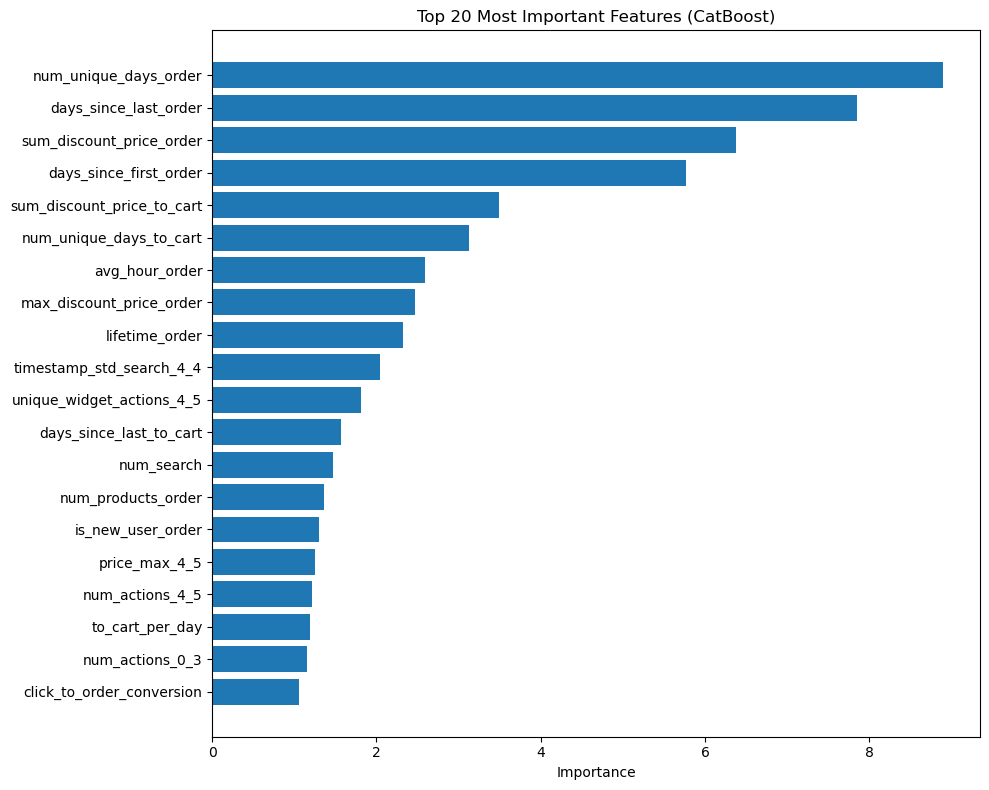

Plot saved to ../models/feature_importance_plot.png


In [18]:
# Plot top 20 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (CatBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'feature_importance_plot.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot saved to {MODELS_DIR}/feature_importance_plot.png")

## 9. ROC Curve and Metrics

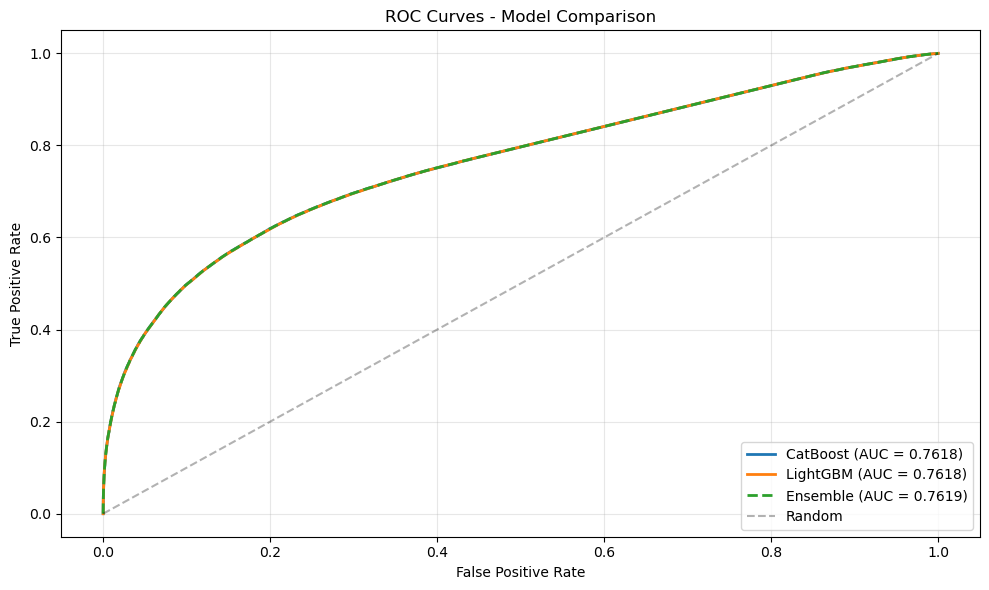

ROC curves saved to ../models/roc_curves.png


In [19]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 6))

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_val, y_pred_catboost_val)
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_catboost:.4f})', linewidth=2)

# LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_val, y_pred_lgb_val)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.4f})', linewidth=2)

# Ensemble
fpr_ens, tpr_ens, _ = roc_curve(y_val, y_pred_ensemble_val)
plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {auc_ensemble:.4f})', linewidth=2, linestyle='--')

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'roc_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"ROC curves saved to {MODELS_DIR}/roc_curves.png")


CLASSIFICATION REPORT (threshold=0.5)

              precision    recall  f1-score   support

    No Order       0.76      0.92      0.83    240085
       Order       0.75      0.47      0.58    126945

    accuracy                           0.76    367030
   macro avg       0.76      0.69      0.70    367030
weighted avg       0.76      0.76      0.74    367030


Confusion Matrix:
[[220228  19857]
 [ 67658  59287]]


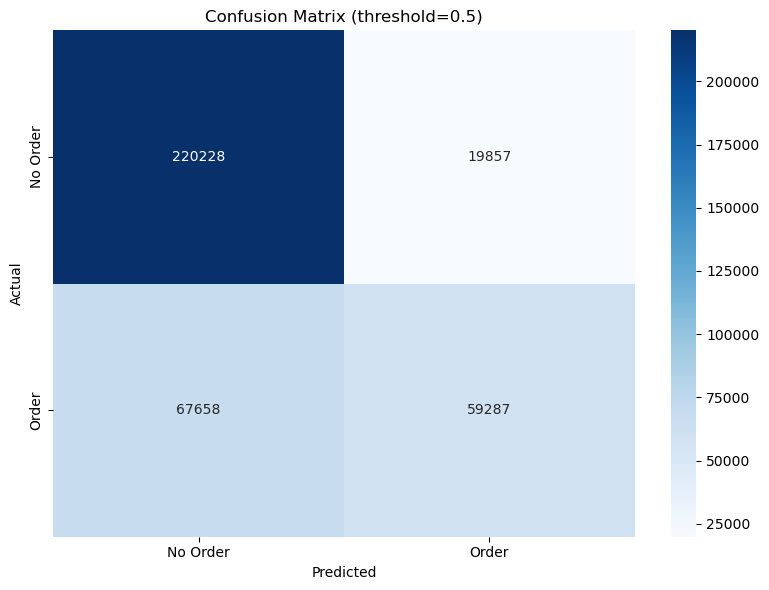

Confusion matrix saved to ../models/confusion_matrix.png


In [20]:
# Classification report (using threshold = 0.5)
threshold = 0.5
y_pred_binary = (y_pred_catboost_val > threshold).astype(int)

print(f"\n{'='*60}")
print(f"CLASSIFICATION REPORT (threshold={threshold})")
print(f"{'='*60}\n")
print(classification_report(y_val, y_pred_binary, target_names=['No Order', 'Order']))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Order', 'Order'],
            yticklabels=['No Order', 'Order'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (threshold={threshold})')
plt.tight_layout()
plt.savefig(os.path.join(MODELS_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to {MODELS_DIR}/confusion_matrix.png")

## 10. Save Models

In [21]:
# Save CatBoost model
model_catboost.save_model(os.path.join(MODELS_DIR, 'catboost_model_v2.bin'))
print(f"CatBoost model saved to {MODELS_DIR}/catboost_model_v2.bin")

# Save LightGBM model
model_lgb.save_model(os.path.join(MODELS_DIR, 'lightgbm_model_v2.txt'))
print(f"LightGBM model saved to {MODELS_DIR}/lightgbm_model_v2.txt")

# Save ensemble weights
import json
ensemble_config = {
    'weight_catboost': weight_catboost,
    'weight_lgb': weight_lgb,
    'validation_auc': {
        'catboost': auc_catboost,
        'lightgbm': auc_lgb,
        'ensemble': auc_ensemble
    }
}

with open(os.path.join(MODELS_DIR, 'ensemble_config_v1.json'), 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print(f"Ensemble config saved to {MODELS_DIR}/ensemble_config.json")

CatBoost model saved to ../models/catboost_model_v2.bin
LightGBM model saved to ../models/lightgbm_model_v2.txt
Ensemble config saved to ../models/ensemble_config.json


## 11. Generate Submission File

In [22]:
# Create submission dataframe
submission = pd.DataFrame({
    'user_id': test_user_ids,
    'predict': y_pred_ensemble_test
})

# Save submission
submission_path = os.path.join(SUBMISSION_DIR, 'submission_v2.csv')
submission.to_csv(submission_path, index=False)

print(f"\n{'='*60}")
print("SUBMISSION GENERATED")
print(f"{'='*60}")
print(f"\nFile: {submission_path}")
print(f"Shape: {submission.shape}")
print(f"\nSample:")
print(submission.head(10))
print(f"\nPrediction statistics:")
print(submission['predict'].describe())


SUBMISSION GENERATED

File: ../results/submission_v2.csv
Shape: (2068424, 2)

Sample:
   user_id   predict
0     1342  0.189590
1     9852  0.746135
2    10206  0.219362
3    11317  0.218697
4    13289  0.679967
5    15846  0.150551
6    25591  0.241112
7    26583  0.172277
8    29834  0.687517
9    32445  0.415331

Prediction statistics:
count    2.068424e+06
mean     3.671057e-01
std      2.278943e-01
min      1.851460e-02
25%      2.011131e-01
50%      2.752230e-01
75%      4.857728e-01
max      9.978961e-01
Name: predict, dtype: float64


## 12. Summary

In [23]:
print("\n" + "="*70)
print("MODEL TRAINING COMPLETE")
print("="*70)

print("\n📊 Results Summary:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print("\n🎯 Model Performance (Validation AUC):")
print(f"  CatBoost:  {auc_catboost:.6f}")
print(f"  LightGBM:  {auc_lgb:.6f}")
print(f"  Ensemble:  {auc_ensemble:.6f} ⭐")

print("\n💾 Saved Files:")
print(f"  - {MODELS_DIR}/catboost_model.bin")
print(f"  - {MODELS_DIR}/lightgbm_model.txt")
print(f"  - {MODELS_DIR}/ensemble_config.json")
print(f"  - {MODELS_DIR}/feature_importance_catboost.csv")
print(f"  - {MODELS_DIR}/feature_importance_plot.png")
print(f"  - {MODELS_DIR}/roc_curves.png")
print(f"  - {MODELS_DIR}/confusion_matrix.png")
print(f"  - {SUBMISSION_DIR}/submission.csv")

print("\n🎯 Next Steps:")
print("  1. Review feature importance - какие фичи самые важные?")
print("  2. Analyze prediction distribution")
print("  3. Create user segmentation (04_user_segmentation.ipynb)")
print("  4. Model evaluation visualizations (05_model_evaluation.ipynb)")

print("\n" + "="*70)


MODEL TRAINING COMPLETE

📊 Results Summary:
  Training samples: 1,468,117
  Validation samples: 367,030
  Test samples: 2,068,424
  Features: 335

🎯 Model Performance (Validation AUC):
  CatBoost:  0.761811
  LightGBM:  0.761814
  Ensemble:  0.761929 ⭐

💾 Saved Files:
  - ../models/catboost_model.bin
  - ../models/lightgbm_model.txt
  - ../models/ensemble_config.json
  - ../models/feature_importance_catboost.csv
  - ../models/feature_importance_plot.png
  - ../models/roc_curves.png
  - ../models/confusion_matrix.png
  - ../results/submission.csv

🎯 Next Steps:
  1. Review feature importance - какие фичи самые важные?
  2. Analyze prediction distribution
  3. Create user segmentation (04_user_segmentation.ipynb)
  4. Model evaluation visualizations (05_model_evaluation.ipynb)



### 13.4 Final Comparison


In [ ]:
# Final comparison
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': [
        'CatBoost (Baseline)',
        'CatBoost (Optimized)',
        'LightGBM (Baseline)',
        'LightGBM (Optimized)',
        'Ensemble (Baseline)',
        'Ensemble (Optimized)'
    ],
    'Validation AUC': [
        auc_catboost,
        auc_catboost_optimized,
        auc_lgb,
        auc_lgb_optimized,
        auc_ensemble,
        optimal_auc
    ],
    'Improvement': [
        0,
        auc_catboost_optimized - auc_catboost,
        0,
        auc_lgb_optimized - auc_lgb,
        0,
        optimal_auc - auc_ensemble
    ]
})

comparison_df = comparison_df.sort_values('Validation AUC', ascending=False)
print("\n", comparison_df.to_string(index=False))

best_model_auc = comparison_df.iloc[0]['Validation AUC']
baseline_auc = auc_ensemble

print(f"\n{'='*70}")
print(f"🏆 Best Model: {comparison_df.iloc[0]['Model']}")
print(f"   AUC: {best_model_auc:.6f}")
print(f"   Total Improvement: {best_model_auc - baseline_auc:+.6f} ({((best_model_auc - baseline_auc) / baseline_auc * 100):+.2f}%)")
print(f"{'='*70}")
